# 【練習問題】民泊サービスの宿泊価格予測

https://signate.jp/competitions/266

### メモ

* データはアメリカのデータ

## データダウンロード

In [ ]:
# データダウンロード
!signate download -c 266 -p ./data

## 定数、インポート定義

In [1]:
# 定数定義

DATA_DIRECTORY = "./data/"
"""データディレクトリ"""

'データディレクトリ'

In [2]:
# インポート定義

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import datetime
from dateutil import tz
import gc
import os
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype
import collections

## メソッド定義

In [3]:
def load_train_data() -> pd.DataFrame:
  """学習データ読み込み

  Returns:
      pd.DataFrame: 学習データを返す 
  """
  file_path = os.path.join(DATA_DIRECTORY, "train.csv")

  return load_data(file_path)

In [4]:
def load_test_data() -> pd.DataFrame:
  """テストデータ読み込み

  Returns:
      pd.DataFrame: テストデータを返す
  """
  file_path = os.path.join(DATA_DIRECTORY, "test.csv")

  return load_data(file_path)

In [5]:
def load_data(file_path: str) -> pd.DataFrame:
  """データ読み込み

  Args:
      file_path (str): データファイルパス

  Returns:
      pd.DataFrame: 読み込んだデータを返す
  """

  df = pd.read_csv(file_path, header=0)
  df = deta_edit(df)
  df = reduce_mem_usage(df)

  return df

In [6]:
def deta_edit(df: pd.DataFrame) -> pd.DataFrame:
  """データ編集

  Args:
      df (pd.DataFrame): ロードデータ

  Returns:
      pd.DataFrame: 編集後のデータを返す
  """

  df["bathrooms"] = df["bathrooms"].fillna(0)
  df["bedrooms"] = df["bedrooms"].fillna(0)
  df["beds"] = df["beds"].fillna(0)
  
  # ベッドの種類
  # df.bed_type = [1 if "Real Bed" == val else 0 for val in df.bed_type ]
  df["bed_type"] = [ edit_bed_type(val) for val in df.bed_type ]

  # キャンセル料
  df["cancellation_policy"] = [ edit_cancellation_policy(val) for val in df.cancellation_policy]

  # 部屋の種類
  df["room_type"] = [ edit_room_type(val) for val in df.room_type ]

  # 都市
  df["city"] = [ edit_city(val) for val in df.city ]

  # 清掃料
  df["cleaning_fee"] = [ 1 if "t" == val else 0 for val in df.cleaning_fee ]

  # ホストの顔写真有無
  df["host_has_profile_pic"] = [ 1 if "t" == val else 0 for val in df.host_has_profile_pic ]

  # ホストの身元確認有無
  df["host_identity_verified"] = [ 1 if "t" == val else 0 for val in df.host_identity_verified ]

  # ホストの返信率
  df["host_response_rate"] = df.host_response_rate.fillna("0%")
  df["host_response_rate"] = df.host_response_rate.str.replace("%", "")
  df["host_response_rate"] = df.host_response_rate.astype(int)

  # ホストの登録日
  init_date = datetime.datetime(1900, 1, 1)
  df["host_since"] = df.host_since.fillna("1900-01-01")
  df["host_since"] = [ datetime.datetime.strptime(val, "%Y-%m-%d") - init_date for val in df.host_since ]
  df["host_since"] = [ val.days for val in df.host_since ]

  # 即時予約可否
  df["instant_bookable"] = [ 1 if "t" == val else 0 for val in df.instant_bookable ]

  # 最終レビュー日
  df["last_review"] = df.last_review.fillna("1900-01-01")
  df["last_review"] = [ datetime.datetime.strptime(val, "%Y-%m-%d") - init_date for val in df.last_review ]
  df["last_review"] = [ val.days for val in df.last_review ]

  # 物件の種類
  df["property_type"] = [ edit_property_type(val) for val in df.property_type ]

  # レビュースコア
  df["review_scores_rating"] = df.review_scores_rating.fillna(0)

  # アメニティーリスト文字列を配列へ展開 
  amenities = df.amenities
  amenities = amenities.str.replace("{|}|\"", "", regex=True)
  amenities = [ val.split(",") for val in amenities ]
  df.amenities = amenities
  
  # アメニティ(Private entrance)
  df["am_private_entrance"] = [ 1 if "Private entrance" in val else 0 for val in df.amenities ]

  # アメニティ(Hair dryer)
  df["am_hair_dryer"] = [ 1 if "Hair dryer" in val else 0 for val in df.amenities ]

  # アメニティ(TV)
  df["am_tv"] = [ 1 if "TV" in val else 0 for val in df.amenities ]

  # アメニティ(Gym)
  df["am_gym"] = [ 1 if "Gym" in val else 0 for val in df.amenities ]

  # アメニティ(Family/kid friendly)
  df["am_family_friendly"] = [ 1 if "Family/kid friendly" in val else 0 for val in df.amenities ]

  # アメニティ(Dryer)
  df["am_dryer"] = [ 1 if "Dryer" in val else 0 for val in df.amenities ]

  # アメニティ(Washer)
  df["am_washer"] = [ 1 if "Washer" in val else 0 for val in df.amenities ]

  # アメニティ(Cable TV)
  df["am_cable_tv"] = [ 1 if "Cable TV" in val else 0 for val in df.amenities ]

  # アメニティ(Pets allowed)
  df["am_pets_allowed"] = [ 1 if "Pets allowed" in val else 0 for val in df.amenities ]

  # アメニティ(Pool)
  df["am_pool"] = [ 1 if "Pool" in val else 0 for val in df.amenities ]

  # アメニティ(Indoor fireplace)
  df["am_indoor_fireplace"] = [ 1 if "Indoor fireplace" in val else 0 for val in df.amenities ]

  # アメニティ(Elevator)
  df["am_elevator"] = [ 1 if "Elevator" in val else 0 for val in df.amenities ]

  # アメニティ(Smoking allowed)
  df["am_smoking_allowed"] = [ 1 if "Smoking allowed" in val else 0 for val in df.amenities ]

  # アメニティ(translation missing: en.hosting_amenity_50)
  df["am_missing50"] = [ 1 if "translation missing: en.hosting_amenity_50" in val else 0 for val in df.amenities ]
  
  # アメニティ(translation missing: en.hosting_amenity_49)
  df["am_missing49"] = [ 1 if "translation missing: en.hosting_amenity_49" in val else 0 for val in df.amenities ]
  
  # 説明 文字数 TODO:説明の文字数と料金に関係が見られないため、除外
  # df["description_length"] = df.description.str.len()

  # 不要カラムを削除
  # df.drop(columns=["room_type", "review_scores_rating", "property_type", "cleaning_fee", "city", "number_of_reviews", "instant_bookable", "host_has_profile_pic", "cancellation_policy", "amenities", "description", "first_review", "host_has_profile_pic", "host_identity_verified", "host_response_rate", "host_since", "instant_bookable", "last_review", "latitude", "longitude", "name", "neighbourhood", "thumbnail_url", "zipcode"], inplace=True)
  # df.drop(columns=["review_scores_rating", "cleaning_fee", "number_of_reviews", "instant_bookable", "host_has_profile_pic", "amenities", "description", "first_review", "host_has_profile_pic", "host_identity_verified", "host_response_rate", "host_since", "instant_bookable", "last_review", "latitude", "longitude", "name", "neighbourhood", "thumbnail_url", "zipcode"], inplace=True)

  df.drop(columns=["description", "first_review", "amenities",  "name", "neighbourhood", "latitude", "longitude", "thumbnail_url", "zipcode"], inplace=True)

  return df

In [7]:
def edit_bed_type(bed_type: str) -> int:
  """ベットの種類 カテゴリ化

  Args:
      bed_type (str): ベッドの種類名

  Returns:
      int: ベッドの種類毎のカテゴリ値を返す
  """

  if "Airbed" == bed_type:
    return 1
  
  if "Couch" == bed_type:
    return 2

  if "Futon" == bed_type:
    return 3

  if "Pull-out Sofa" == bed_type:
    return 4
  
  if "Real Bed" == bed_type:
    return 5
  
  return 0

In [8]:
def edit_room_type(room_type: str) -> int:
  """部屋の種類 カテゴリ化

  Args:
      room_type (str): 部屋の種類名

  Returns:
      int: 部屋の種類毎のカテゴリ値を返す
  """

  if "Shared room" == room_type:
    return 1
  
  if "Private room" == room_type:
    return 2
  
  if "Entire home" == room_type:
    return 3
  
  return 0


In [9]:
def edit_city(city_name: str) -> int:
  """都市 カテゴリ化

  Args:
      city_name (str): 都市名

  Returns:
      int: 都市名毎のカテゴリ値を返す
  """
  
  if "Boston" == city_name:
    return 1
  
  if "LA" == city_name:
    return 2
  
  if "NYC" == city_name:
    return 3
  
  if "DC" == city_name:
    return 4
  
  if "SF" == city_name:
    return 5
  
  if "Chicago" == city_name:
    return 6
  
  return 0

In [10]:
def edit_cancellation_policy(cancellation_policy: str) -> int:
  """キャンセル料 カテゴリ化

  Args:
      cancellation_policy (str): キャンセル料名

  Returns:
      int: キャンセル料名毎のカテゴリ値を返す
  """

  if "flexible" == cancellation_policy:
    return 1

  if "strict" == cancellation_policy:
    return 2
  
  if "moderate" == cancellation_policy:
    return 3

  if "super_strict_30" == cancellation_policy:
    return 4

  if "super_strict_60" == cancellation_policy:
    return 5
  
  return 0

In [11]:
def edit_property_type(property_type: str) -> int:
  """物件の種類 カテゴリ化

  Args:
      property_type (str): 物件の種類名

  Returns:
      int: 物件の種類毎のカテゴリ値
  """

  if "Apartment" == property_type:
    return 1

  if "House" == property_type:
    return 2
  
  if "Townhouse" == property_type:
    return 3

  if "Loft" == property_type:
    return 4

  if "Cabin" == property_type:
    return 5

  if "Condominium" == property_type:
    return 6

  if "Guest suite" == property_type:
    return 7

  if "Guesthouse" == property_type:
    return 8

  if "Other" == property_type:
    return 9

  if "Bungalow" == property_type:
    return 10

  if "Villa" == property_type:
    return 11

  if "Bed & Breakfast" == property_type:
    return 12

  if "Dorm" == property_type:
    return 13

  if "Timeshare" == property_type:
    return 14

  if "Camper/RV" == property_type:
    return 15

  if "Cave" == property_type:
    return 16

  if "Hostel" == property_type:
    return 17

  if "Earth House" == property_type:
    return 18

  if "In-law" == property_type:
    return 19

  if "Serviced apartment" == property_type:
    return 20

  if "Boat" == property_type:
    return 21

  if "Tent" == property_type:
    return 22

  if "Castle" == property_type:
    return 23

  if "Boutique hotel" == property_type:
    return 24

  if "Vacation home" == property_type:
    return 25

  if "Hut" == property_type:
    return 26

  if "Treehouse" == property_type:
    return 27

  if "Yurt" == property_type:
    return 28

  if "Chalet" == property_type:
    return 29

  if "Island" == property_type:
    return 30

  if "Tipi" == property_type:
    return 31

  if "Train" == property_type:
    return 32

  if "Parking Space" == property_type:
    return 33

  if "Casa particular" == property_type:
    return 34
  
  return 0

In [12]:
def reduce_mem_usage(df: pd.DataFrame, use_float16: bool = False) -> pd.DataFrame:
    """ロードしたデータを型変換し、容量を削減する

    Args:
        df (pd.DataFrame): ロードデータ
        use_float16 (bool, optional): float16使用フラグ デフォルト値：False

    Returns:
        pd.DataFrame: 容量削減後のデータを返す
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## 学習実行

In [13]:
train_df = load_train_data()
test_df = load_test_data()

Memory usage of dataframe is 14.84 MB
Memory usage after optimization is: 3.18 MB
Decreased by 78.6%
Memory usage of dataframe is 4.81 MB
Memory usage after optimization is: 0.95 MB
Decreased by 80.1%


In [14]:
train_df.describe()

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,am_dryer,am_washer,am_cable_tv,am_pets_allowed,am_pool,am_indoor_fireplace,am_elevator,am_smoking_allowed,am_missing50,am_missing49
count,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000,...,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000,55583.000000
mean,27791.000000,3.152906,1.233156,4.933955,1.263696,1.708814,1.956767,3.003562,0.734415,0.994279,...,0.576561,0.582174,0.326665,0.137776,0.084558,0.125326,0.146394,0.049404,0.339492,0.275570
std,16045.574343,2.153001,0.585755,0.428017,0.849979,1.258744,0.752804,1.167807,0.441648,0.075422,...,0.494108,0.493206,0.468998,0.344668,0.278226,0.331091,0.353504,0.216711,0.473541,0.446805
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13895.500000,2.000000,1.000000,5.000000,1.000000,1.000000,1.000000,2.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27791.000000,2.000000,1.000000,5.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,41686.500000,4.000000,1.000000,5.000000,1.000000,2.000000,3.000000,3.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,55582.000000,16.000000,8.000000,5.000000,10.000000,18.000000,5.000000,6.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
# データを目的変数と特徴量変数に分割する
target = train_df.y
features = train_df.drop(columns=["y", "id"])
# del train_df
# gc.collect()

In [29]:
# カテゴリ変数リスト
categorical_features = ["bed_type", "cancellation_policy", "city", "cleaning_fee", "host_has_profile_pic", "host_identity_verified", "instant_bookable", "property_type" ]

# パラメーター設定
params = {
    "objective": "regression", # 目的関数：回帰
    "boosting": "gbdt", # 勾配ブースティング
    # "seed": 314, #シード値
    "num_leaves": 300, # 決定木の端末ノードの数
    # "max_depth": 7, #決定木の深さ
    "learning_rate": 0.1, # 学習率
    "feature_fraction": 0.85, # 特徴量の削減率 ※1未満の場合、特徴量を削減して学習される
    "reg_lambda": 2, # L2正則化項の係数 ※過学習を防ぐために用いる関数のパラメータ
    "metric": "rmse", # モデルの性能を測る指標 ※二乗平均平方根誤差
    "force_row_wise": True, # 行ベースのヒストグラムを生成する
    "verbose": -1
}

# シード値
seeds = [438,5848, 37]

# 早期停止
earlyStoppingcallback = early_stopping(10)

# ログ出力頻度
logEvaluationCallback = log_evaluation(5)

# 学習実行
cnt = 0
shuffle_seed = 4398
kf = KFold(n_splits=3, shuffle=True, random_state=shuffle_seed)
models = []
for train_index, test_index in kf.split(features):
    train_features = features.loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = features.loc[test_index]
    test_target = target.loc[test_index]

    # データセット作成    
    d_training = lgb.Dataset(train_features, label=train_target, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target, free_raw_data=False)
    
    params["seed"] = seeds[cnt]

    # 学習実行
    model = lgb.train(
        params,
        train_set=d_training,
        num_boost_round=200,
        valid_sets=[d_training, d_test],
        categorical_feature=categorical_features,
        callbacks=[
            earlyStoppingcallback,
            logEvaluationCallback
        ]
    )
    
    models.append(model)
    cnt += 1
    
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()



/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bed_type', 'cancellation_policy', 'city', 'cleaning_fee', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'property_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
[5]	training's rmse: 135.495	valid_1's rmse: 135.799
[10]	training's rmse: 117.661	valid_1's rmse: 122.65
[15]	training's rmse: 107.595	valid_1's rmse: 116.61
[20]	training's rmse: 101.262	valid_1's rmse: 114.022
[25]	training's rmse: 96.2572	valid_1's rmse: 112.803
[30]	training's rmse: 92.3658	valid_1's rmse: 112.309
[35]	training's rmse: 89.2027	valid_1's rmse: 111.992
[40]	training's rmse: 86.4619	valid_1's rmse: 111.9
[45]	training's rmse: 83.9213	valid_1's rmse: 111.994
Early stopping, best iteration is:
[38]	training's rmse: 87.6143	valid_1's rmse: 111.874


/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bed_type', 'cancellation_policy', 'city', 'cleaning_fee', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'property_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[5]	training's rmse: 133.601	valid_1's rmse: 141.968
[10]	training's rmse: 115.965	valid_1's rmse: 127.724
[15]	training's rmse: 105.812	valid_1's rmse: 121.099
[20]	training's rmse: 99.6921	valid_1's rmse: 117.888
[25]	training's rmse: 95.0877	valid_1's rmse: 115.98
[30]	training's rmse: 91.5342	valid_1's rmse: 115.137
[35]	training's rmse: 88.2882	valid_1's rmse: 114.7
[40]	training's rmse: 85.5395	valid_1's rmse: 114.482
[45]	training's rmse: 83.044	valid_1's rmse: 114.25
Early stopping, best iteration is:
[38]	training's rmse: 87.6143	valid_1's rmse: 111.874


/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bed_type', 'cancellation_policy', 'city', 'cleaning_fee', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'property_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[5]	training's rmse: 134.832	valid_1's rmse: 136.575
[10]	training's rmse: 117.103	valid_1's rmse: 123.023
[15]	training's rmse: 106.944	valid_1's rmse: 117.043
[20]	training's rmse: 100.574	valid_1's rmse: 114.429
[25]	training's rmse: 95.8142	valid_1's rmse: 113.274
[30]	training's rmse: 91.972	valid_1's rmse: 112.836
[35]	training's rmse: 88.8232	valid_1's rmse: 112.91
[40]	training's rmse: 85.8941	valid_1's rmse: 112.934
[45]	training's rmse: 83.2624	valid_1's rmse: 113.048
Early stopping, best iteration is:
[38]	training's rmse: 87.6143	valid_1's rmse: 111.874


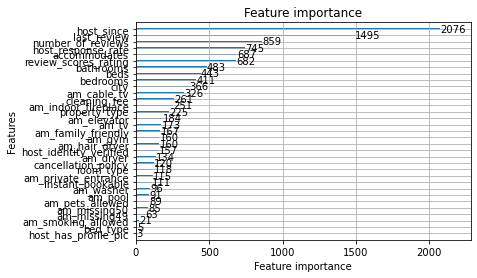

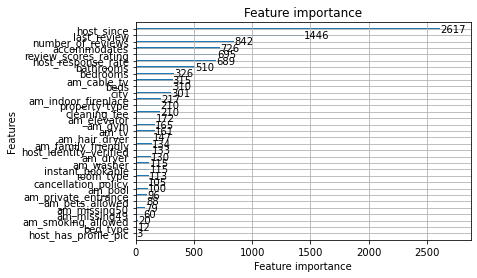

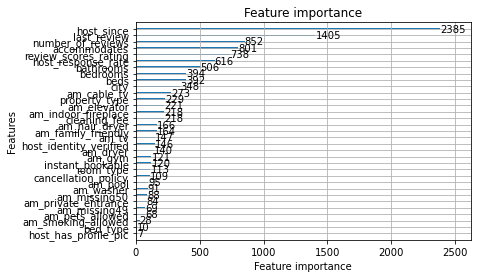

In [30]:
# 学習結果をプロット
for model in models:
    lgb.plot_importance(model)
    plt.show()
    # lgb.create_tree_digraph(model)

## 推定実行

In [31]:
test_id = test_df.id
test_features = test_df.drop(columns=["id"])

In [32]:
results = []
for model in models:
    # 推定
    predicts = pd.Series(model.predict(test_features, num_iteration=model.best_iteration) / len(models), name="y")

    # 推定結果を集計
    if  results == []:
        results = predicts.values / len(models)
    else:
        results += predicts.values / len(models)
    
    # del model
    del predicts
    gc.collect()

/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_9837/2352902196.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if  results == []:


In [33]:
results_df = pd.DataFrame({"id": test_id, "y": np.clip(results, 0, a_max=None)})
results_df.to_csv("submission.csv", index=False, header=False)

In [71]:
# 結果提出
!signate submit -c 266 ./submission.csv

You have successfully submitted your predictions.We will send you the submission result to your email address.


---

## モデル追加

In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from dtreeviz.trees import dtreeviz
from IPython.display import SVG

In [16]:
# データ編集
tree_target = train_df.y
tree_features = train_df.drop(columns=["y", "id"])

In [35]:
# 回帰木作成
model_tree = DecisionTreeRegressor(
              criterion='mse', # RMSEではないが、ルートを取るかの違いのため、一旦良しとする
              splitter='best',
              max_depth=1000,
              # min_samples_split=2,
              # min_samples_leaf=1,
              # min_weight_fraction_leaf=0.0,
              # max_features=None,
              random_state=None,
              # max_leaf_nodes=None,
              # min_impurity_decrease=0.0,
              # ccp_alpha=0.0
            )

model_tree.fit(tree_features, tree_target)

/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


DecisionTreeRegressor(criterion='mse', max_depth=1000)

こんな対応が必要そう  
https://qiita.com/onodism/items/329efd2aeeef54937794

In [23]:
# 回帰木の分岐の仕方を可視化
viz = dtreeviz(model_tree, tree_features, tree_target, target_name="y")


viz = dtreeviz(model_tree,
               tree_features,
               tree_target,
               target_name='price')
viz.view()


/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/python_3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
dyld[9887]: Library not loaded: '/usr/local/lib/libgvc.6.dylib'
  Referenced from: '/usr/local/bin/dot'
  Reason: tried: '/usr/local/lib/libgvc.6.dylib' (no such file), '/usr/lib/libgvc.6.dylib' (no such file)


CalledProcessError: Command '['dot', '-Tsvg', '-o', '/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/DTreeViz_9837.svg', '/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/DTreeViz_9837']' died with <Signals.SIGABRT: 6>. [stderr: b"dyld[9887]: Library not loaded: '/usr/local/lib/libgvc.6.dylib'\n  Referenced from: '/usr/local/bin/dot'\n  Reason: tried: '/usr/local/lib/libgvc.6.dylib' (no such file), '/usr/lib/libgvc.6.dylib' (no such file)\n"]

In [36]:
# 推定データ編集
tree_test_features = test_df.drop(columns=["id"])

In [38]:
# 推定実行
tree_pred = model_tree.predict(tree_test_features)

In [39]:
# 提出データ作成
results_df = pd.DataFrame({"id": test_id, "y": np.clip(tree_pred, 0, a_max=None)})
results_df.to_csv("submission.csv", index=False, header=False)

In [40]:
# 結果提出
!signate submit -c 266 ./submission.csv

You have successfully submitted your predictions.We will send you the submission result to your email address.


---

## 以下、調査用

### アメニティ項目の確認

In [12]:
amenities = train_df.amenities

In [55]:
amenities = amenities.str.replace("{|}", "", regex=True)

In [54]:
def amenity_count(series: pd.Series) -> collections.Counter :
  """全アメニティーをカウントする

  Args:
      series (pd.Series): アメニティーデータ

  Returns:
      collections.Counter: カウント結果を返す
  """
  
  ser_vals = []

  for row in series:
    for val in row.split(","):
      ser_vals.append(val.replace('"',''))

  counter = collections.Counter(ser_vals)
  
  return counter


In [56]:
count = amenity_count(amenities)

In [57]:
count_items = sorted(count.items(), key=lambda x:x[1], reverse=True)

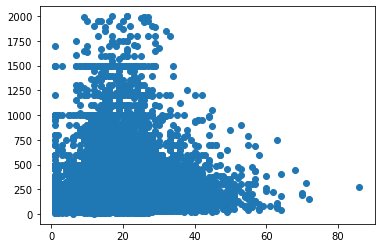

In [65]:
plt.scatter(train_df.amenity_count, train_df.y)

アメニティの数は価格に直接的な影響は与えていないように見える

In [13]:
train_df.amenities

0        {TV,"Wireless Internet",Kitchen,"Free parking ...
1        {TV,"Cable TV",Internet,"Wireless Internet","A...
2        {TV,Internet,"Wireless Internet",Kitchen,"Indo...
3        {TV,"Cable TV",Internet,"Wireless Internet","A...
4        {TV,Internet,"Wireless Internet","Air conditio...
                               ...                        
55578    {TV,"Cable TV",Internet,"Wireless Internet","A...
55579    {TV,Internet,"Wireless Internet","Air conditio...
55580    {TV,Internet,"Wireless Internet",Kitchen,Heati...
55581    {TV,"Wireless Internet","Air conditioning",Poo...
55582    {TV,"Cable TV",Internet,"Wireless Internet","A...
Name: amenities, Length: 55583, dtype: category
Categories (51031, object): ['{"Air conditioning","Carbon monoxide detector..., '{"Air conditioning","Elevator in building",He..., '{"Air conditioning","Fire extinguisher",Essen..., '{"Air conditioning","Free parking on premises..., ..., '{Washer,Dryer,Internet,"Smoke detector","Wire..., '{Washer,Dryer

In [171]:
def mean_by_amenities(df):
  # 重複しないアメニティのリストを作成
  amenities_list = []
  for amenities in df.amenities:
    amenities_list.extend(amenities)

  amenities_set = set(amenities_list)
  amenities_set.remove('')

  res = pd.DataFrame([],columns=["amenity", "exist_count", "exist_y_mean",  "not_exist_y_mean"])

  for amenity in amenities_set:
    exist_df = df[[ amenity in amenities for amenities in df.amenities ]]
    not_exist_df = df[[ amenity not in amenities for amenities in df.amenities ]]
    
    exist_y_mean = exist_df.y.mean()
    not_exist_y_mean = not_exist_df.y.mean()
    
    mean_df = {
      "amenity": amenity,
      "exist_count": len(exist_df),
      "exist_y_mean": exist_y_mean,
      "not_exist_y_mean": not_exist_y_mean
    }

    res = res.append(mean_df, ignore_index=True)

    del exist_df
    del not_exist_df
    del mean_df

  return res

In [173]:
price_mean_by_amenity = mean_by_amenities(train_df)

/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_11669/563486265.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(mean_df, ignore_index=True)
/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_11669/563486265.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(mean_df, ignore_index=True)
/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_11669/563486265.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(mean_df, ignore_index=True)
/var/folders/km/rlhv761j4rqcrksj6ch5bw_r0000gn/T/ipykernel_11669/563486265.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

#### 価格に影響がありそうなアメニティリスト
※平均価格から20ドル程度以上乖離があり、ある程度対象設定されている件数が存在するものを対象にする

##### 料金が高いアメニティ
* "Private entrance"
* "Hair dryer"
* TV
* Gym
* "Family/kid friendly"
* Dryer
* Washer
* "Cable TV"
* "Pets allowed"
* Pool
* "Indoor fireplace"
* Elevator

##### 料金が安いアメニティ
* "Smoking allowed"
* "translation missing: en.hosting_amenity_50"
* "translation missing: en.hosting_amenity_49"


### 都市項目の確認

In [64]:
train_df.city

0             LA
1             DC
2            NYC
3             SF
4            NYC
          ...   
55578        NYC
55579    Chicago
55580         SF
55581         LA
55582         LA
Name: city, Length: 55583, dtype: category
Categories (6, object): ['Boston', 'Chicago', 'DC', 'LA', 'NYC', 'SF']

アメリカの6都市が設定されている

In [63]:
test_df.city

0         Boston
1             LA
2            NYC
3            NYC
4             LA
          ...   
18523        NYC
18524    Chicago
18525    Chicago
18526        NYC
18527         LA
Name: city, Length: 18528, dtype: category
Categories (6, object): ['Boston', 'Chicago', 'DC', 'LA', 'NYC', 'SF']

テストデータについても同様の都市のみが設定されている

In [72]:
train_city_counter = collections.Counter(train_df.city)
test_city_counter = collections.Counter(test_df.city)

In [74]:
train_city_counter.items()

dict_items([('LA', 16828), ('DC', 4259), ('NYC', 24326), ('SF', 4768), ('Chicago', 2807), ('Boston', 2595)])

In [75]:
test_city_counter.items()

dict_items([('Boston', 873), ('LA', 5625), ('NYC', 8023), ('DC', 1429), ('SF', 1666), ('Chicago', 912)])

都市データの分布は学習データ、テストデータでほとんど同じ

| 都市 | 学習データ件数 | 学習データ割合 | テストデータ件数 | テストデータ割合 |
| - | - | - | - | - |
| LA | 16828 | 30.28% | 5625 | 30.36% |
| DC | 4259 | 7.66% | 1429 | 7.71% |
| NYC | 24326 | 43.77% | 8023 | 43.30% |
| SF | 4768 | 8.58% | 1666 | 8.99% |
| Chicago | 2807 | 5.05% | 912 | 4.92% |
| Boston | 2595 | 4.67% | 873 | 4.71% |
| 合計 | 55583 | - | 18528 | - |

<AxesSubplot:xlabel='y', ylabel='Count'>

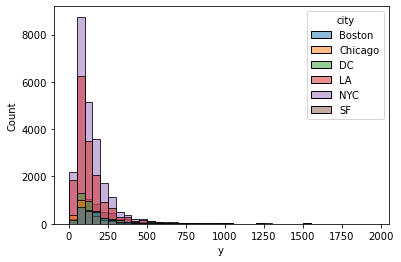

In [10]:
import seaborn as sns
sns.histplot(x="y", data=train_df, bins=range(0, 2000, 50), hue="city")

In [11]:
def plot_hist_by_city(df: pd.DataFrame):
  """都市毎の宿泊価格ヒストグラム出力

  Args:
      df (pd.DataFrame): ロードデータ
  """
  cities = df.city.unique()

  for city in cities:
    plot_data = df[df.city == city]
    plt.hist(plot_data.y, bins=range(0, 2000, 50))
    plt.title(city)
    plt.show()

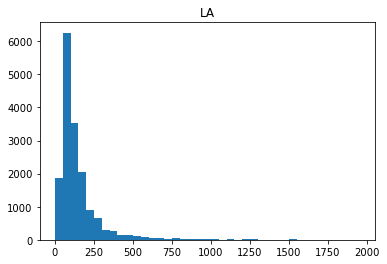

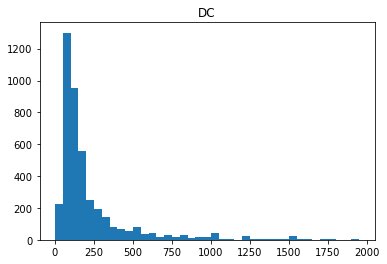

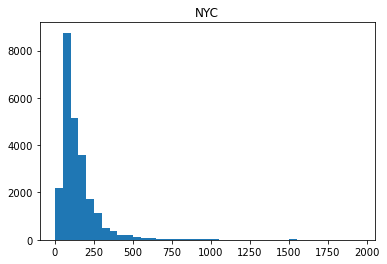

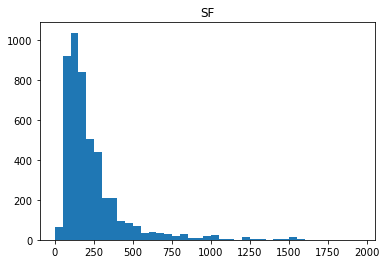

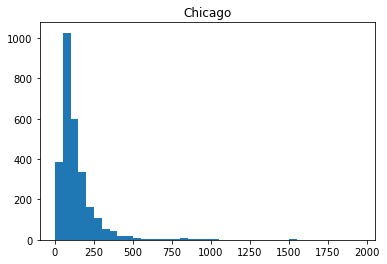

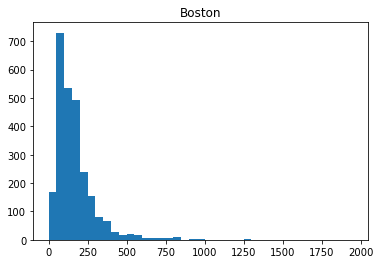

In [12]:
plot_hist_by_city(train_df)

都市毎の価格分布の形状はほとんど同じ  
サンフランシスコが若干、価格が高い  

### ベッドの種類

In [13]:
train_df.bed_type

0        Real Bed
1        Real Bed
2        Real Bed
3        Real Bed
4        Real Bed
           ...   
55578    Real Bed
55579    Real Bed
55580    Real Bed
55581    Real Bed
55582    Real Bed
Name: bed_type, Length: 55583, dtype: category
Categories (5, object): ['Airbed', 'Couch', 'Futon', 'Pull-out Sofa', 'Real Bed']

In [16]:
def plot_hist_by_bed_type(df: pd.DataFrame):
  """ベッドの種類毎の宿泊価格ヒストグラム出力

  Args:
      df (pd.DataFrame): ロードデータ
  """
  bed_types = df.bed_type.unique()

  for bed_type in bed_types:
    plot_data = df[df.bed_type == bed_type]
    plt.hist(plot_data.y, bins=range(0, 2000, 50))
    plt.title(bed_type)
    plt.show()

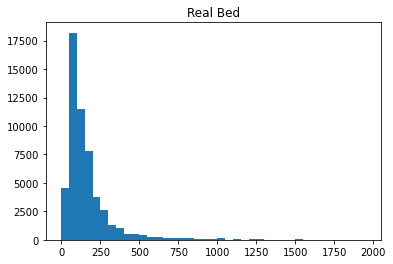

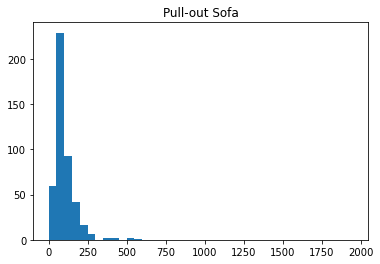

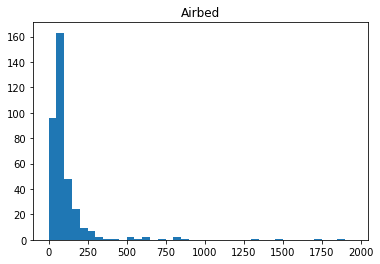

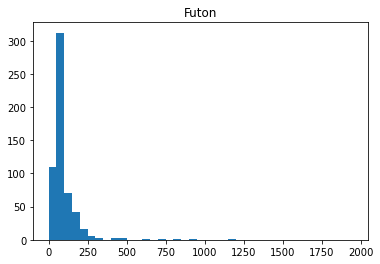

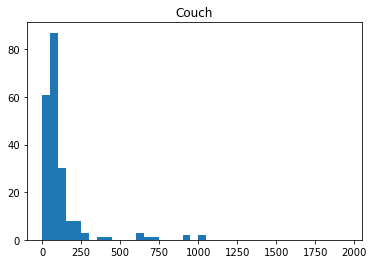

In [17]:
plot_hist_by_bed_type(train_df)

In [20]:
bed_type_counter = collections.Counter(train_df.bed_type)

In [21]:
bed_type_counter.items()

dict_items([('Real Bed', 53989), ('Pull-out Sofa', 453), ('Airbed', 364), ('Futon', 569), ('Couch', 208)])

ベッドの物件の方が価格が高い傾向にある  
※ヒストグラムの中心から右側(価格が高い方)の変化がなだらかであるため  
データのほとんどがベッドの物件のため、モデルに設定しても、あまり効果が薄いと思われる  
※やるならベッドか否かのダミー変数にする  

### 物件の種類

In [30]:
train_df.property_type

0        Apartment
1            House
2        Apartment
3        Apartment
4        Apartment
           ...    
55578    Apartment
55579    Apartment
55580    Apartment
55581    Townhouse
55582    Apartment
Name: property_type, Length: 55583, dtype: category
Categories (34, object): ['Apartment', 'Bed & Breakfast', 'Boat', 'Boutique hotel', ..., 'Treehouse', 'Vacation home', 'Villa', 'Yurt']

In [31]:
train_property_type_counter = collections.Counter(train_df.property_type)

In [32]:
train_property_type_counter

Counter({'Apartment': 36826,
         'House': 12326,
         'Townhouse': 1249,
         'Loft': 914,
         'Cabin': 47,
         'Condominium': 1983,
         'Guest suite': 96,
         'Guesthouse': 392,
         'Other': 448,
         'Bungalow': 281,
         'Villa': 131,
         'Bed & Breakfast': 349,
         'Dorm': 112,
         'Timeshare': 55,
         'Camper/RV': 71,
         'Cave': 1,
         'Hostel': 51,
         'Earth House': 4,
         'In-law': 60,
         'Serviced apartment': 16,
         'Boat': 53,
         'Tent': 14,
         'Castle': 9,
         'Boutique hotel': 50,
         'Vacation home': 11,
         'Hut': 7,
         'Treehouse': 7,
         'Yurt': 8,
         'Chalet': 4,
         'Island': 1,
         'Tipi': 3,
         'Train': 2,
         'Parking Space': 1,
         'Casa particular': 1})

### 説明

物件の説明が設定されている。
最大で1000文字まで設定されている。
※説明が1000文字以上の場合は先頭1000文字まで設定されている

ex. id=8 のデータ
```
Very bright & cozy private room right in the heart of North Beach- a very short walking distance from Fisherman's Wharf, Pier 39, Coit Tower, Lombard Street, Pier 33 (Alcatraz Pier), Chinatown, & cruise/ferry terminals; one block from all public transportation, including cable cars, with a relaxing, beautiful garden! Built in 1907, this house on Greenwich Street is on the grounds of the first cemetery in San Francisco. The room is comfortable & cozy & you are assured a great night's rest. The building comes with the charms of one erected over 100 years ago, so please keep that in mind. With one of the best & most relaxing gardens in all of North Beach. The pictures speak for themselves as far as describing the room. I am happy to try to accommodate anything you need. Please ask if I may do anything to make your time here more enjoyable. There are no laundry facilities on site, however, there is a laundromat & two wash & fold drop-off establishments within one block of the house. I am t
```

In [13]:
train_df.description.str.len()

0         379
1         406
2         467
3        1000
4        1000
         ... 
55578    1000
55579    1000
55580     239
55581     756
55582     131
Name: description, Length: 55583, dtype: int64

In [22]:
def plot_hist_by_description_lengh(df: pd.DataFrame):
  """説明文字数のヒストグラム出力

  Args:
      df (pd.DataFrame): ロードデータ
  """

  plt.hist(df.description_length, bins=range(0, 1000, 50))
  plt.title("description_length")
  plt.show()

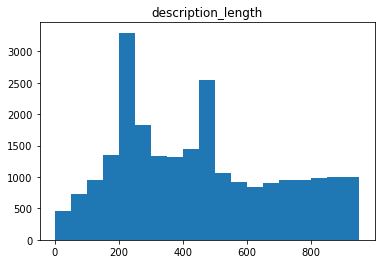

In [23]:
plot_hist_by_description_lengh(train_df)

In [19]:
def plot_scatter_by_description_lengh(df: pd.DataFrame):
  """説明文字数の宿泊価格散布図出力

  Args:
      df (pd.DataFrame): ロードデータ
  """

  plt.scatter(df.description_length, df.y)
  plt.title("description_length")
  plt.show()

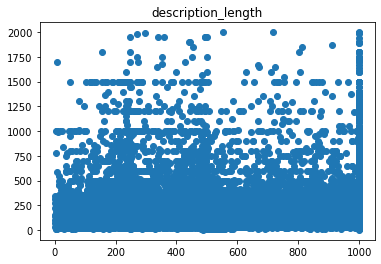

In [20]:
plot_scatter_by_description_lengh(train_df)

説明文の文字数と価格は直接的な関係は関係は無い様に見える

### キャンセル料

In [24]:
cancellation_policy_counter = collections.Counter(train_df.cancellation_policy)

In [25]:
cancellation_policy_counter.items()

dict_items([('flexible', 16886), ('strict', 24318), ('moderate', 14288), ('super_strict_30', 78), ('super_strict_60', 13)])

In [32]:
def plot_hist_by_cancellation_policy(df: pd.DataFrame):
  """キャンセル料の宿泊価格ヒストグラム出力

  Args:
      df (pd.DataFrame): ロードデータ
  """
  cancellation_policies = df.cancellation_policy.unique()

  for cancellation_policy in cancellation_policies:
    plot_data = df[df.cancellation_policy == cancellation_policy]
    plt.hist(plot_data.y, bins=range(0, 2000, 50))
    plt.title(cancellation_policy)
    plt.show()

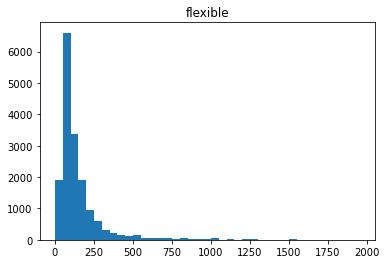

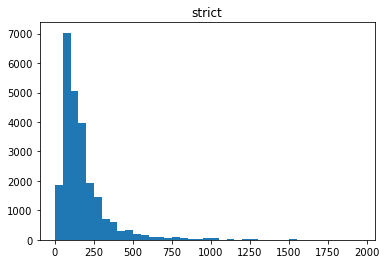

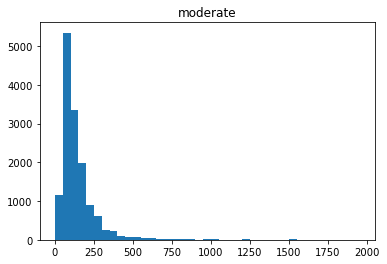

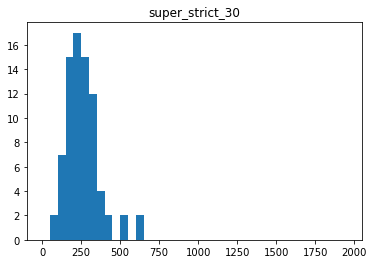

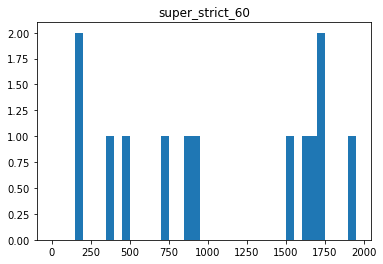

In [33]:
plot_hist_by_cancellation_policy(train_df)

おおよそ下記のような傾向が見られた。  
```
flexible　< strict < moderate < super_strict_30 < super_strict_60
```  
順序変数として扱うことができれば、良さそう。  

### ホストの情報

In [34]:
host_has_profile_pic_counter = collections.Counter(train_df.host_has_profile_pic)
host_identity_verified_counter = collections.Counter(train_df.host_identity_verified)

In [35]:
host_has_profile_pic_counter

Counter({'t': 55265, nan: 148, 'f': 170})

In [36]:
host_identity_verified_counter

Counter({'f': 18171, 't': 37264, nan: 148})

In [37]:
def plot_hist_by_host_has_profile_pic(df: pd.DataFrame):
  """ホストの写真有無の宿泊価格ヒストグラム出力

  Args:
      df (pd.DataFrame): ロードデータ
  """
  has_host_pic_flags = df.host_has_profile_pic.unique()

  for has_host_pic_flag in has_host_pic_flags:
    plot_data = df[df.host_has_profile_pic == has_host_pic_flag]
    plt.hist(plot_data.y, bins=range(0, 2000, 50))
    plt.title(has_host_pic_flag)
    plt.show()

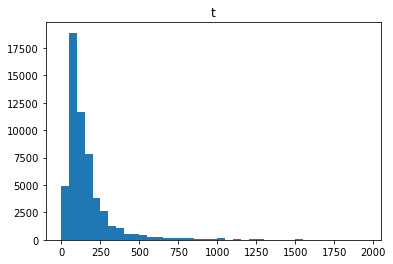

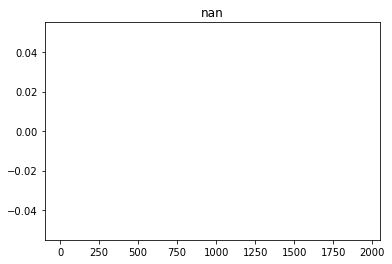

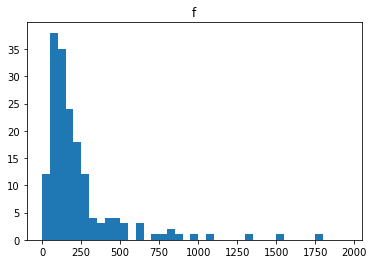

In [39]:
plot_hist_by_host_has_profile_pic(train_df)

ホストの写真の有無は価格に影響していない様に見える

In [40]:
def plot_hist_by_host_identity_verified(df: pd.DataFrame):
  """ホストの写真有無の宿泊価格ヒストグラム出力

  Args:
      df (pd.DataFrame): ロードデータ
  """
  host_identity_verified_flags = df.host_identity_verified.unique()

  for host_identity_verified_flag in host_identity_verified_flags:
    plot_data = df[df.host_identity_verified == host_identity_verified_flag]
    plt.hist(plot_data.y, bins=range(0, 2000, 50))
    plt.title(host_identity_verified_flag)
    plt.show()

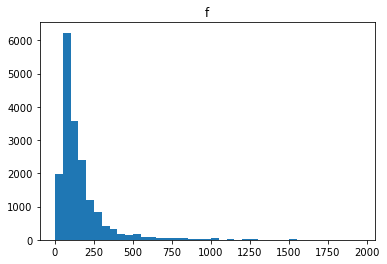

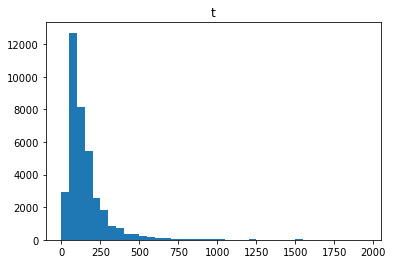

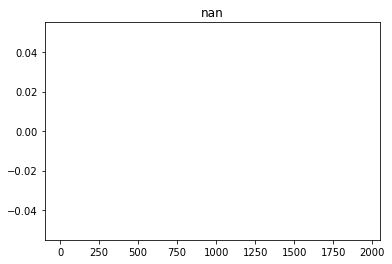

In [41]:
plot_hist_by_host_identity_verified(train_df)

ホストの写真の有無は価格に影響していない様に見える

### 即時予約可否

In [42]:
instant_bookable_counter = collections.Counter(train_df.instant_bookable)

In [43]:
instant_bookable_counter

Counter({'f': 41034, 't': 14549})

In [44]:
def plot_hist_by_instant_bookable(df: pd.DataFrame):
  """即時予約可否の宿泊価格ヒストグラム出力

  Args:
      df (pd.DataFrame): ロードデータ
  """
  instant_bookable_flags = df.instant_bookable.unique()

  for instant_bookable_flag in instant_bookable_flags:
    plot_data = df[df.instant_bookable == instant_bookable_flag]
    plt.hist(plot_data.y, bins=range(0, 2000, 50))
    plt.title(instant_bookable_flag)
    plt.show()

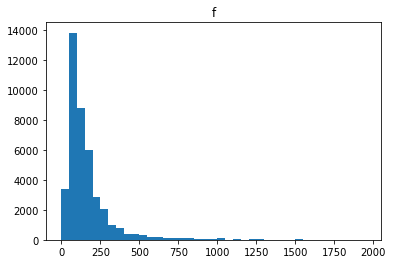

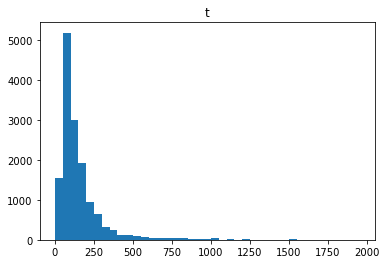

In [45]:
plot_hist_by_instant_bookable(train_df)

即時予約の有無は価格に影響はなさそう

### レビュー数

In [52]:
def plot_scatter_by_number_of_reviews(df: pd.DataFrame):
  """レビュー数の宿泊価格散布図出力

  Args:
      df (pd.DataFrame): ロードデータ
  """

  plt.scatter(df.number_of_reviews, df.y)
  plt.title("number_of_reviews")
  plt.show()

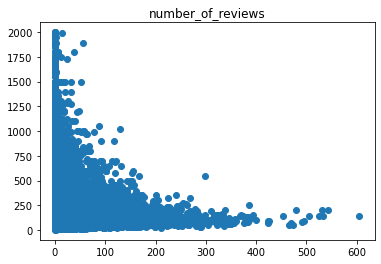

In [51]:
plot_scatter_by_number_of_reviews(train_df)

価格が低い物件はレビュー数が多いものから少ないものまで幅広く分布しているが、  
価格が高い物件はレビュー数が少ないはレビューが低いものがほとんど  
⇨価格が低い物件は利用者が多く、その分レビュワーが多くなっている  
⇨⇨価格が低いからレビュー数が多いという因果関係のため、レビュー数はモデルに組み込まない方が良さそう

### レビュースコア

In [55]:
def plot_scatter_by_review_scores_rating(df: pd.DataFrame):
  """レビュースコアの宿泊価格散布図出力

  Args:
      df (pd.DataFrame): ロードデータ
  """

  plt.scatter(df.review_scores_rating, df.y)
  plt.title("review_scores_rating")
  plt.show()

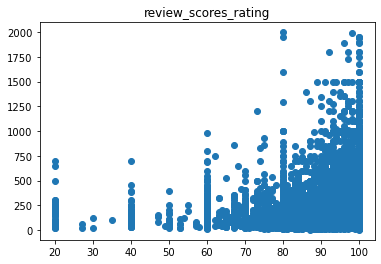

In [56]:
plot_scatter_by_review_scores_rating(train_df)

レビュースコアと価格は直接的な関係は見られなかった  
⇨スコアは満足度を表すため、コストパフォーマンスを表す値になっていそう



### 部屋の種類

In [57]:
room_type_counter = collections.Counter(train_df.room_type)

In [58]:
room_type_counter.items()

dict_items([('Private room', 23023), ('Entire home/apt', 30939), ('Shared room', 1621)])

In [59]:
def plot_hist_by_room_type(df: pd.DataFrame):
  """部屋の種類の宿泊価格ヒストグラム出力

  Args:
      df (pd.DataFrame): ロードデータ
  """
  
  room_types = df.room_type.unique()

  for room_type in room_types:
    plot_data = df[df.room_type == room_type]
    plt.hist(plot_data.y, bins=range(0, 2000, 50))
    plt.title(room_type)
    plt.show()

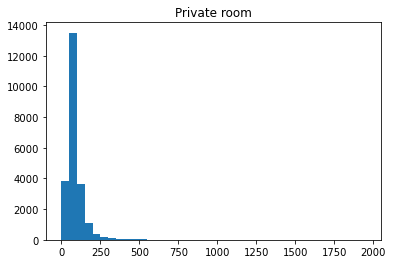

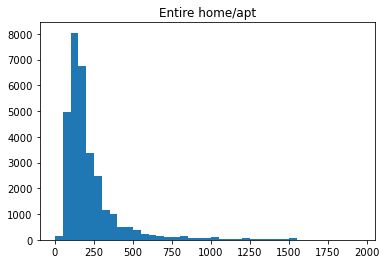

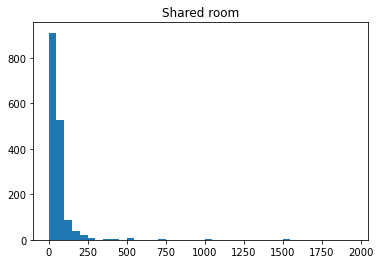

In [60]:
plot_hist_by_room_type(train_df)

価格順は下記の傾向が見られた
```
Shared room < Private room < Entire home
```